# Takeaways

- Frobenius norm for matrices
- Python matrix broadcasting
- Nearest neighbor classifier
  - Nearest neighbor distances: Euclidean
  - Nearest neighbor distances: Manhattan
- k-Nearest neighbor classifier
- Cross-validation for k-Nearest Neighbor classifiers
  - i.e. How to figure out the best *k*
- I skipped the optimization/vectorization of the kNN no-loop test function because my implementation is crashing the kernel (probably due to memory overload)

----
# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During **training**, the classifier takes the training data and simply remembers it
- During **testing**, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from   cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

----
## Note: Download dataset CIFAR-10

You will need to download the [CIFAR-10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html). Run the following from the assignment1 directory:

```
$ cd cs231n/datasets
$ ./get_datasets.sh
```

__WARNING:__ If you're on a Mac, then you'll have to modify `get_datasets.sh` to download the files via `curl` and not `wget`: 
>```curl "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" -o "cifar-10-python.tar.gz"```

#### CIFAR-10
> The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 


In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print 'Training data shape:\t\t'  , X_train.shape
print 'Training labels shape:\t\t', y_train.shape
print 'Test data shape:\t\t'      , X_test.shape
print 'Test labels shape:\t\t'    , y_test.shape

Training data shape:		(50000, 32, 32, 3)
Training labels shape:		(50000,)
Test data shape:		(10000, 32, 32, 3)
Test labels shape:		(10000,)


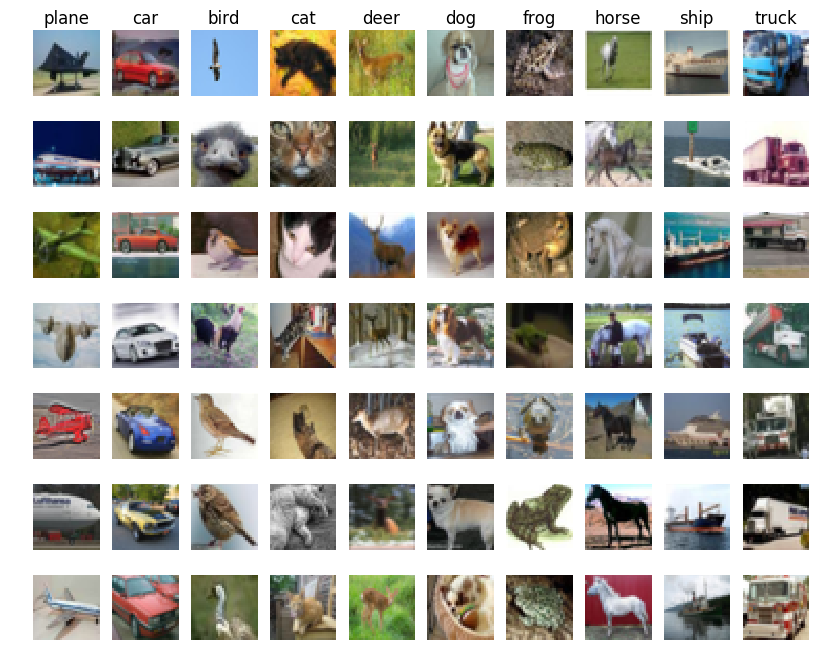

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes           = ['plane', 'car', 'bird', 'cat', 'deer', 
                     'dog', 'frog', 'horse', 'ship', 'truck']
num_classes       = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask         = range(num_training)
X_train      = X_train[mask]
y_train      = y_train[mask]

num_test     = 500
mask         = range(num_test)
X_test       = X_test[mask]
y_test       = y_test[mask]

In [6]:
# Reshape the image data into rows
X_train      = np.reshape(X_train, (X_train.shape[0], -1))
X_test       = np.reshape(X_test, (X_test.shape[0], -1))
print X_train.shape, X_test.shape

(5000, 3072) (500, 3072)


In [7]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [8]:
i = 1
j = 1
# print classifier.X_train[j]
# print X_test[i]
# print np.sqrt(np.sum(np.square(classifier.X_train[j] - X_test[i]), axis=1))
foo = np.sqrt(np.sum(np.square(classifier.X_train[j,:] - X_test[i,:]), axis=0))
print foo

5270.28006846


In [9]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print dists.shape

(500, 5000)


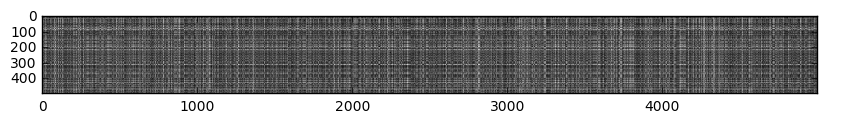

In [10]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [11]:
# My notes: implementing `predict_labels` method

# TODO:                                                                 #
# Use the distance matrix to find the k nearest neighbors of the ith    #
# testing point, and use self.y_train to find the labels of these       #
# neighbors. Store these labels in closest_y.                           #
# Hint: Look up the function numpy.argsort.                             #
        
k = 5
i = 1
    


# A list of length k storing the labels of the k nearest neighbors to
# the ith test point.
closest_y = []
#########################################################################
# TODO:                                                                 #
# Use the distance matrix to find the k nearest neighbors of the ith    #
# testing point, and use self.y_train to find the labels of these       #
# neighbors. Store these labels in closest_y.                           #
# Hint: Look up the function numpy.argsort.                             #
#########################################################################
sorted_idxs   = np.argsort(dists[i,:])[0:k,]
closest_y     = classifier.y_train[sorted_idxs]
#########################################################################
# TODO:                                                                 #
# Now that you have found the labels of the k nearest neighbors, you    #
# need to find the most common label in the list closest_y of labels.   #
# Store this label in y_pred[i]. Break ties by choosing the smaller     #
# label.                                                                #
#########################################################################
from scipy.stats import mode
y_pred =  mode(np.sort(closest_y), axis=None).mode[0]
print y_pred

8


In [12]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy    = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [13]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy    = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

In [14]:
# Notes: COMPUTE_DISTANCES_ONE_LOOP optimization

# Get an idea of the inputs
# print "Train data:\t", classifier.X_train.shape
# print "Test data:\t", X_test.shape

# i = 1 # ith test data


# # print np.sqrt(np.sum(np.square(classifier.X_train - X_test[i]), axis=1)).shape
# print (classifier.X_train - X_test[i,:]).shape
# print (X_test[i,:]- classifier.X_train).shape


# print classifier.X_train.shape
# print X_test.shape
# print (classifier.X_train[:,np.newaxis,:]).shape
# print (X_test[np.newaxis,:,:]).shape

# diff_foo = classifier.X_train[:,np.newaxis,:] - X_test[np.newaxis,:,:]
# print diff_foo.shape

# >>> a = np.array([0.0, 10.0, 20.0, 30.0])
# >>> b = np.array([1.0, 2.0, 3.0])
# >>> a[:, np.newaxis] + b
# array([[  1.,   2.,   3.],
#        [ 11.,  12.,  13.],
#        [ 21.,  22.,  23.],
#        [ 31.,  32.,  33.]])
# Here the newaxis index operator inserts a new axis into a, 
# making it a two-dimensional 4x1 array. Combining the 4x1 array with b, 
# which has shape (3,), yields a 4x3 array.



#### Frobenius Norm

To decide whether 2 matrices are similar look at the **Frobenius norm** of the 2 matrices. The Frobenius norm is the square root of the square sum of differences of all elements.

`numpy.linalg.norm(matrix_a - matrix_b, ord='fro'`

In [15]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

Difference was: 0.000000
Good! The distance matrices are the same


# No-loop optimization/vectorization

Use [broadcasting to take a cross-difference](http://stackoverflow.com/questions/35961972/broadcast-function-in-numpy-similar-to-matrix-multiplication): `y[:,None,:]-x[None,:,:]`

`d = np.sqrt(np.sum((y[:,None,:]-x[None,:,:])**2,axis=-1))`

----
### [**Warning:** Memory growth w/ broadcast operations in numpy](http://stackoverflow.com/questions/31536504/memory-growth-with-broadcast-operations-in-numpy)

do the operation in smaller batches is a good one. You could also try using the function np.subtract and give it the destination array to avoid creating an addtional temporary array. I also think you don't need to index c as c[np.newaxis, :, :], because it is already a 3-d array.

So instead of

> `a[:] = b[:, :, np.newaxis] - c[np.newaxis, :, :] # memory explodes here`

try

> `np.subtract(b[:, :, np.newaxis], c, a)`

The third argument of np.subtract is the destination array.

http://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc
> Broadcasting is a powerful tool for writing short and usually intuitive code that does its computations very efficiently in C. However, there are cases when broadcasting uses unnecessarily large amounts of memory for a particular algorithm. In these cases, it is better to write the algorithm's outer loop in Python. This may also produce more readable code, as algorithms that use broadcasting tend to become more difficult to interpret as the number of dimensions in the broadcast increases.


----
### Quora

> As Divakar already mentioned, the simplest option is probably `scipy.spatial.distance.cdist`:
> 
> ```
> from scipy.spatial.distance import cdist
>   
> distances = cdist(y, x)                 # Euclidean
> distances = cdist(y, x, 'mahalanobis')  # Mahalanobis
> ```
>
> This is single-threaded but fast. You could also use `np.linalg.norm`:
> 
> ```
> distances = np.linalg.norm(y[:, None, :] - x[None, :, :], axis=2)   # Euclidean
> ```
> This broadcasts out the difference calculation over pairs of rows in x and y to create an intermediate array of shape (3, 3, 3), then computes the Euclidean norm over the last axis. This is multithreaded, but involves constructing an intermediate array that might be quite large if x and y have lots of rows (it also doesn't exploit the symmetry of the distance matrix).
> It would be fairly straightforward to generalize the second method to compute Mahalanobis distance instead of Euclidean distance (I'll leave this part for you to figure out...).

----
### Resources
- [Visualization of python broadcasting](http://scipy.github.io/old-wiki/pages/EricsBroadcastingDoc)
- 





In [ ]:
# 1st, broadcast the difference calculation over the first 2 dimensions
# 2nd, compute the euclidean norm over the last axis
dists = np.linalg.norm(classifier.X_train[:,np.newaxis ,:] - X_test[np.newaxis,:,:], axis=-1)


In [ ]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print 'Difference was: %f' % (difference, )
if difference < 0.001:
  print 'Good! The distance matrices are the same'
else:
  print 'Uh-oh! The distance matrices are different'

In [51]:
# Let's compare how fast the implementations are
def time_function(f, *args):
  """
  Call a function f with args and return the time (in seconds) that it took to execute.
  """
  import time
  tic = time.time()
  f(*args)
  toc = time.time()
  return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print 'Two loop version took %f seconds' % two_loop_time

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print 'One loop version took %f seconds' % one_loop_time

# no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
# print 'No loop version took %f seconds' % no_loop_time

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 48.922476 seconds
One loop version took 56.551084 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [68]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################
X_train_folds = np.array_split(classifier.X_train, num_folds)
y_train_folds = np.array_split(classifier.y_train, num_folds)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

print len(X_train_folds)
print len(y_train_folds)

5
5


In [70]:
# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################
 
# iterate through all values of k
#   itereate through num_folds
#     - leave one fold out for test-validation
#     - train on the rest of the folds
#     - predict labels (given k)
#     - compute accuracy (given test-validation fold)

maxK = 10

for i,k in enumerate(np.arange(1,maxK)):
    for j, iFold in enumerate(np.arange(num_folds)):
        X_train_folds = np.array_split(classifier.X_train, num_folds)
        y_train_folds = np.array_split(classifier.y_train, num_folds)

        Xfold_validation = X_train_folds.pop(iFold) 
        yfold_validation = y_train_folds.pop(iFold)
        
        X_train_folds = np.concatenate(X_train_folds)
        y_train_folds = np.concatenate(y_train_folds)
        
        classifier = KNearestNeighbor()
        classifier.train(X_train_folds, y_train_folds)
        dists       = classifier.compute_distances_one_loop(Xfold_validation)
        y_test_pred = classifier.predict_labels(dists, k=k)
        num_correct = np.sum(y_test_pred == yfold_validation)
        k_to_accuracies[k] = float(num_correct) / num_test

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print 'k = %d, accuracy = %f' % (k, accuracy)

/Users/jason/anaconda3/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:41: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


AttributeError: 'tuple' object has no attribute 'mode'

In [ ]:
# plot the raw observations
for k in k_choices:
  accuracies = k_to_accuracies[k]
  plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 1

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print 'Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy)